In [2]:
import os
import torch
import matplotlib.pyplot as plt
import yaml
from datetime import datetime
from env_wrapper import BoardsWrapper
from env_internals import BoardsImplementation
from agent_architecture import AgentParams, PPOAgent, RandomAgent, save_agents, load_agents
from misc_utils import smooth_list, find_latest_version
from training_loop import train_agents, save_stats, load_stats

## Set parameters

In [3]:
# game params
size = 4
n_landmarks = 1
n_clues = 1
n_questions = 0
max_moves = size ** 2 * 4
history_len = 4
instant_reward_multiplier = 2.0
end_reward_multiplier = 10.0

# seeds
env_seed = 12
sender_seed = 135
receiver_seed = 246
torch_seed = 45954
torch.manual_seed(torch_seed)
torch.cuda.manual_seed(torch_seed)

# training params
batch_size = 8
n_epochs = 5 # for agents
training_epochs = 10
n_episodes = 10000
gamma = 0.99
alpha = 2e-4
gae_lambda = 0.95
policy_clip = 0.1
hidden_size = size ** 2 * 32

# other
model_version = 0
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## Functions: plot drawing and env init

### Plot drawing functions

In [4]:
def plot_stats(smoothing_window, all_performances, title, file_path, save=True, show=False):
    if not all_performances:
        return
    smoothed_total = smooth_list(all_performances,smoothing_window)

    plt.figure(figsize=(12, 6))
    plt.plot(smoothed_total)
    plt.xlabel("Episode")
    plt.ylabel("Smoothed Performance")
    plt.title(title)
    if show:
        plt.show()
    if save:
        plt.savefig(os.path.join(file_path, f"{title}.png"), bbox_inches='tight')

### Enviroment init function

In [5]:
def create_env():
    env_internals = BoardsImplementation(
        size,
        n_landmarks,
        n_clues,
        n_questions,
        seed=env_seed
    )
    env = BoardsWrapper(
        env_internals,
        max_moves,
        history_len,
        instant_reward_multiplier,
        end_reward_multiplier,
        device
    )
    return env

## Training

Agents setup

In [6]:
sender_parameters = AgentParams(gamma,
                                alpha,
                                gae_lambda,
                                policy_clip,
                                batch_size,
                                n_epochs,
                                sender_seed)
receiver_parameters = AgentParams(gamma,
                                  alpha,
                                  gae_lambda,
                                  policy_clip,
                                  batch_size,
                                  n_epochs,
                                  receiver_seed)

Env setup

In [7]:
env = create_env()
sender_agent = PPOAgent(
    size,
    history_len,
    env.sender_n_actions,
    hidden_size,
    device,
    sender_parameters
)

receiver_agent = PPOAgent(
    size,
    history_len,
    env.receiver_n_actions,
    hidden_size,
    device,
    receiver_parameters
)

Agents training

In [8]:
all_stats = {}
for i in range(training_epochs):
    stats = train_agents(env, sender_agent, receiver_agent, n_episodes)
    for key in stats:
        if key not in all_stats:
            all_stats[key] = []
        all_stats[key].extend(stats[key])
    # env.render() # create and save animation

Episode 0, Performance: 0.1056
Episode 1, Performance: -0.6125
Episode 2, Performance: -0.1180
Episode 3, Performance: -6.2111
Episode 4, Performance: 0.0000
Episode 5, Performance: -0.1402
Episode 6, Performance: -0.4142
Episode 7, Performance: -3.4721
Episode 8, Performance: 0.2929
Episode 9, Performance: -0.1180
Episode 0, Performance: 0.2929
Episode 1, Performance: -0.4142
Episode 2, Performance: -2.6056
Episode 3, Performance: -1.0000
Episode 4, Performance: -2.1623
Episode 5, Performance: -0.0607
Episode 6, Performance: -1.1213
Episode 7, Performance: 0.0000
Episode 8, Performance: 0.2929
Episode 9, Performance: 0.1056
Episode 0, Performance: -1.2361
Episode 1, Performance: 0.2929
Episode 2, Performance: 0.1679
Episode 3, Performance: -0.4142
Episode 4, Performance: -2.0000
Episode 5, Performance: -1.8284
Episode 6, Performance: -0.1180
Episode 7, Performance: -0.4142
Episode 8, Performance: 0.5000
Episode 9, Performance: 0.3798
Episode 0, Performance: -0.4142
Episode 1, Performa

## Save params, stats, plots and agents

### Data folder containing stats, plots and agents folders

Data folder setup

In [9]:
timestamp = datetime.now().strftime("%H%M%S_%Y%m%d")
data_folder = f"experiments/data_{timestamp}"
os.makedirs(data_folder, exist_ok = True)

### Create yaml file with current experiment params

In [10]:
experiment_params = {
    'game': {
        'size': size,
        'n_landmarks': n_landmarks,
        'n_clues': n_clues,
        'n_questions': n_questions,
        'max_moves': max_moves,
        'history_len': history_len,
        'instant_reward_multiplier': instant_reward_multiplier,
        'end_reward_multiplier': end_reward_multiplier
    },
    'seeds': {
        'env_seed': env_seed,
        'sender_seed': sender_seed,
        'receiver_seed': receiver_seed,
        'torch_seed': torch_seed
    },
    'training': {
        'batch_size': batch_size,
        'n_epochs': n_epochs,
        'n_episodes': n_episodes,
        'training_epochs': training_epochs,
        'gamma': gamma,
        'alpha': alpha,
        'gae_lambda': gae_lambda,
        'policy_clip': policy_clip,
        'hidden_size': hidden_size
    },
    'device': device,
    'timestamp': datetime.now().strftime("%H%M%S_%Y%m%d")
}

In [11]:
params_path = os.path.join(data_folder, f"experiment_params.yaml")
with open(params_path, 'w') as f:
    yaml.dump(experiment_params, f, default_flow_style=False)
print(f"Saved params to {params_path}")

Saved params to ./data_145359_20260202\experiment_params.yaml


### Agents

Models folder setup

In [12]:
models_folder = os.path.join(data_folder, "models")
os.makedirs(models_folder, exist_ok=True)
agents_file_name = f"agents"

Save agents

In [13]:
save_agents(sender_agent, receiver_agent, os.path.join(models_folder, f"{agents_file_name}.pkl"))

### Stats

Stats folder setup

In [14]:
stats_folder = os.path.join(data_folder, "stats")
os.makedirs(stats_folder, exist_ok = True)
stats_file_name = f"stats"

Save stats

In [15]:
save_stats(stats, os.path.join(stats_folder, f"{stats_file_name}.pkl"))

### Plots

Plots folder setup

In [16]:
plots_folder = os.path.join(data_folder, "plots")
os.makedirs(plots_folder, exist_ok = True)

Create and save plots

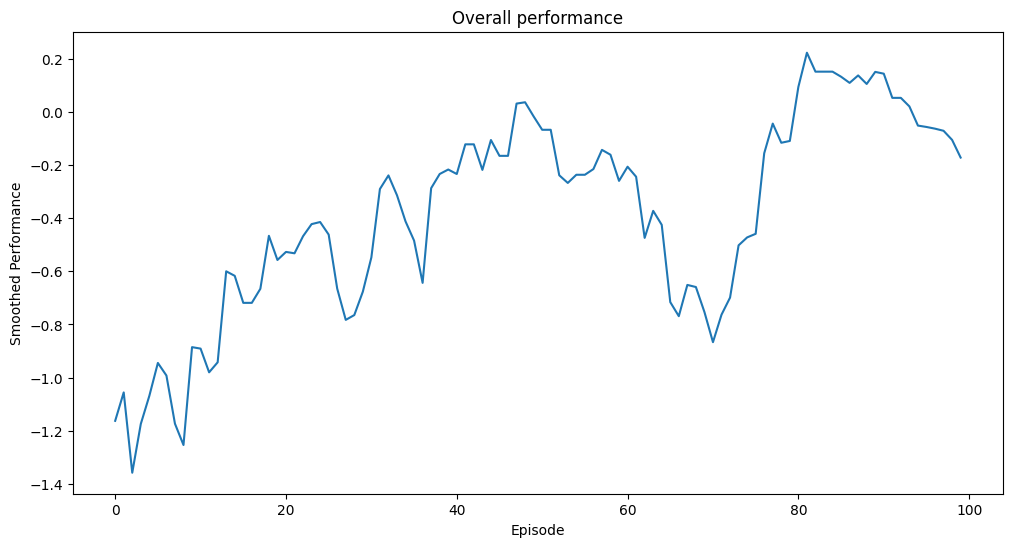

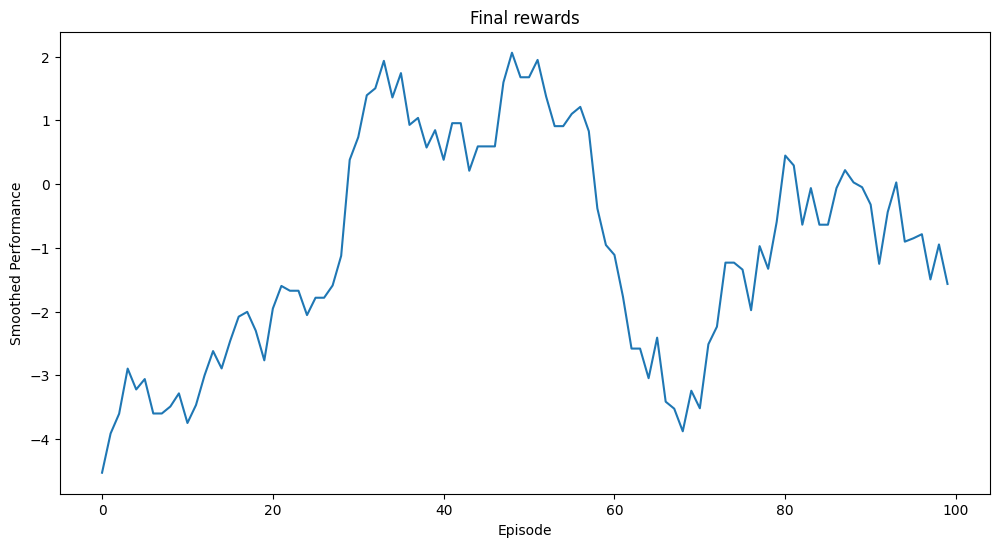

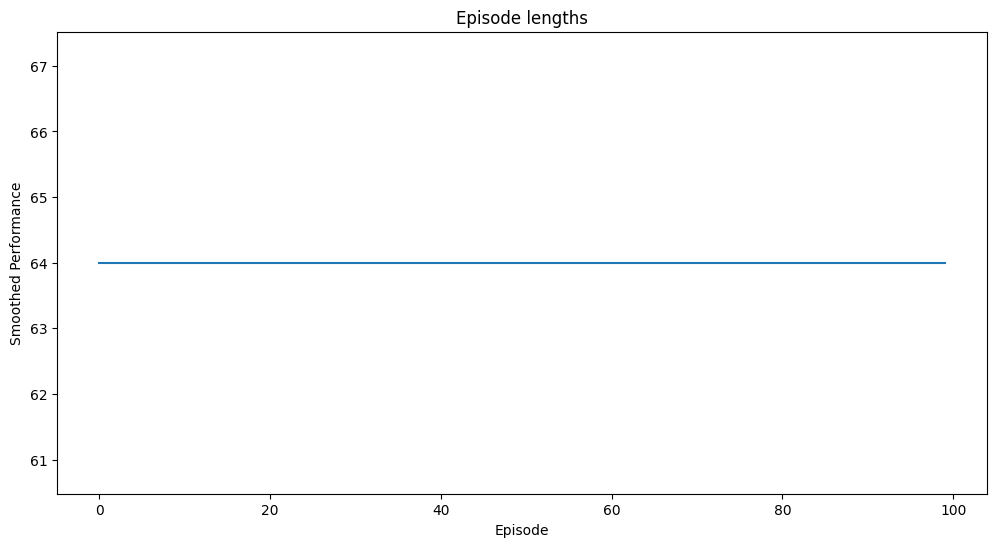

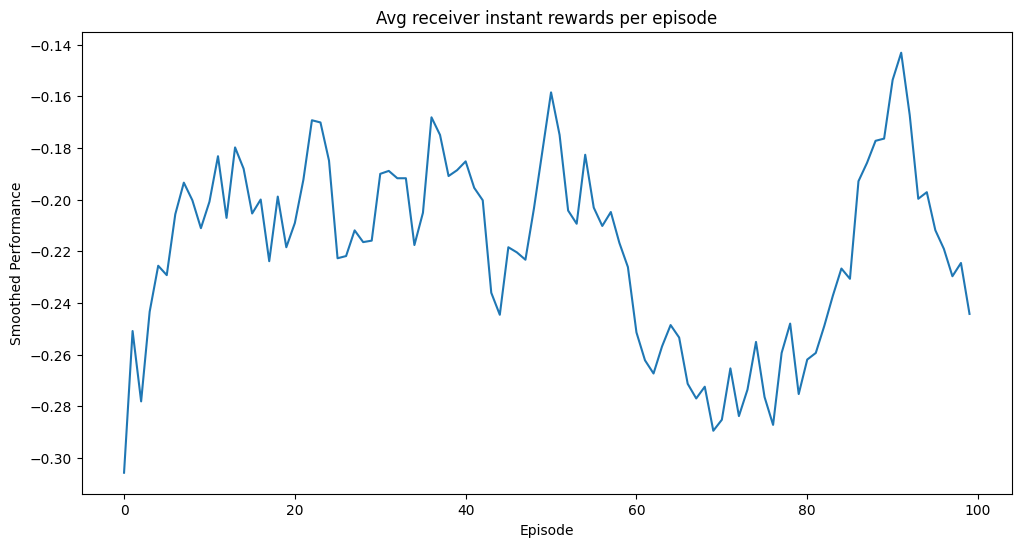

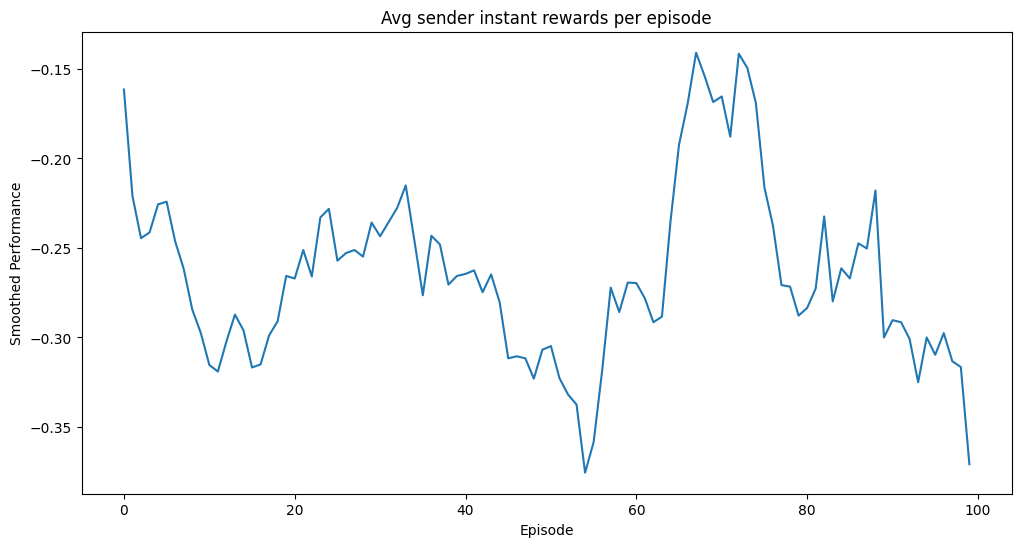

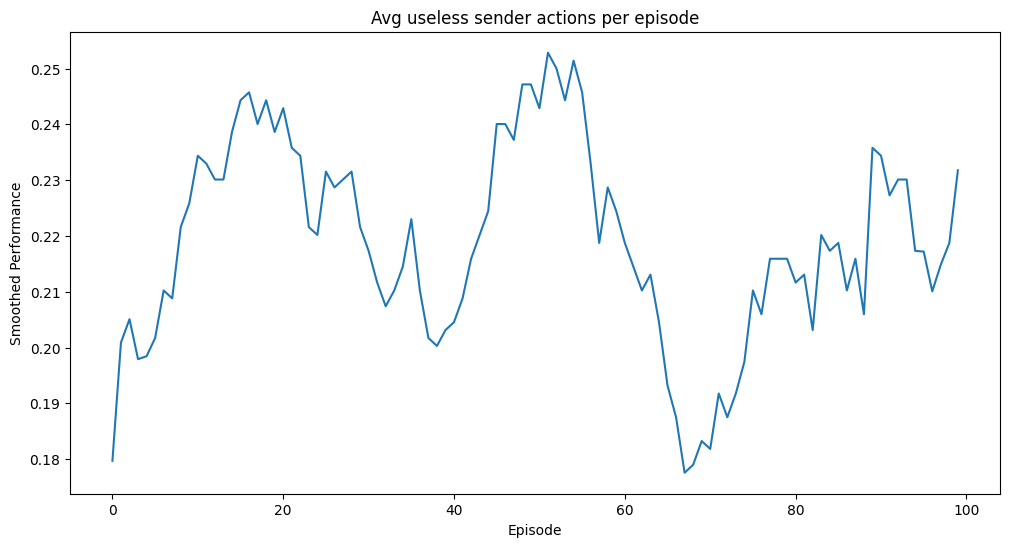

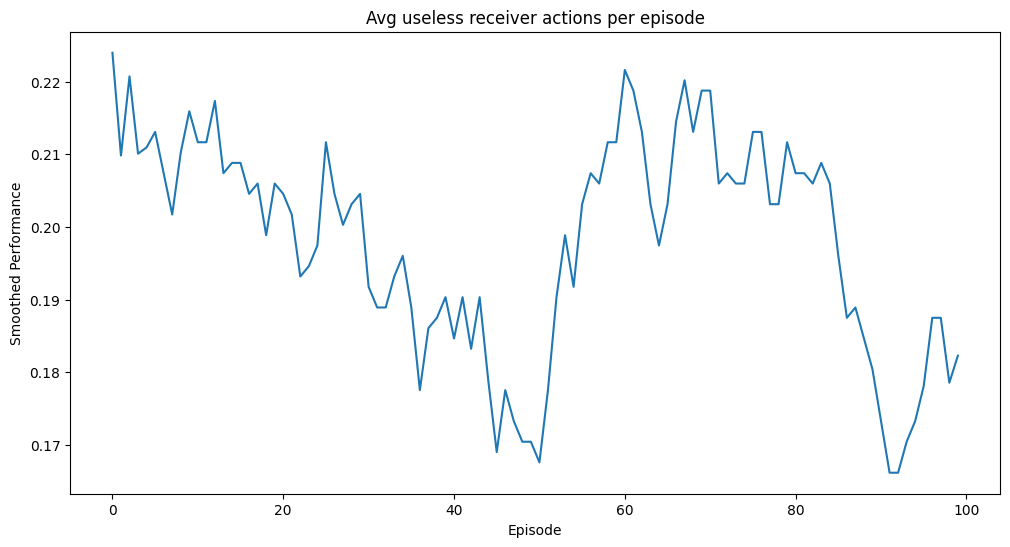

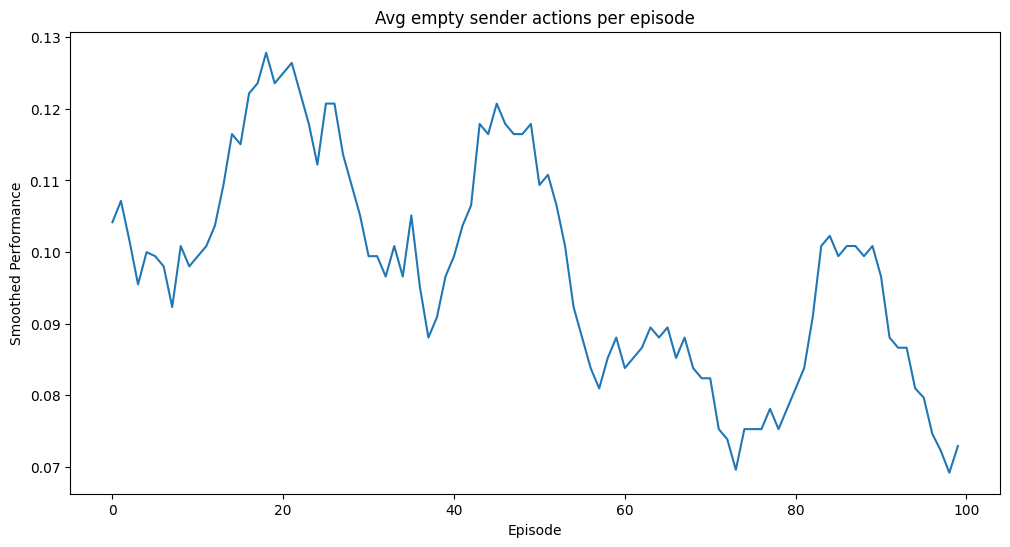

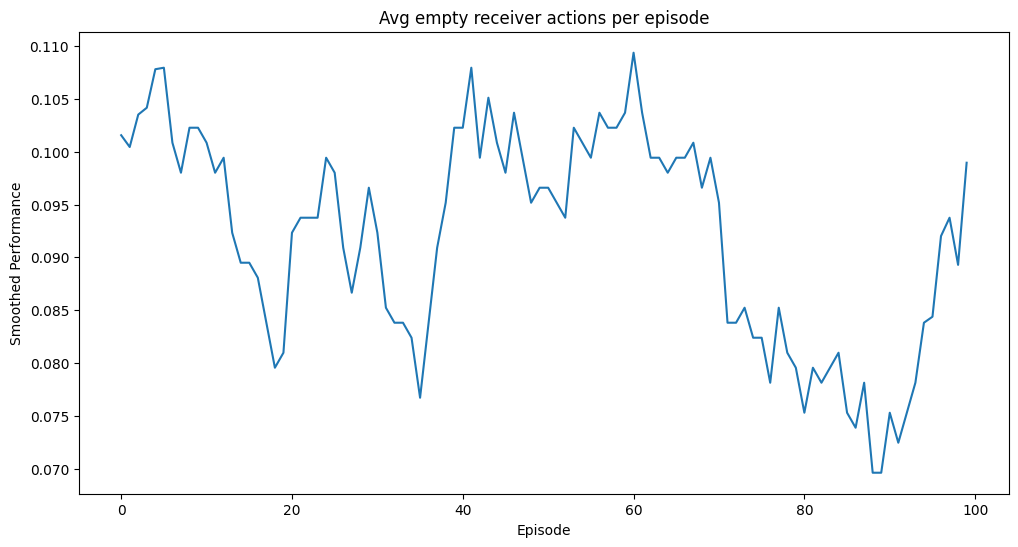

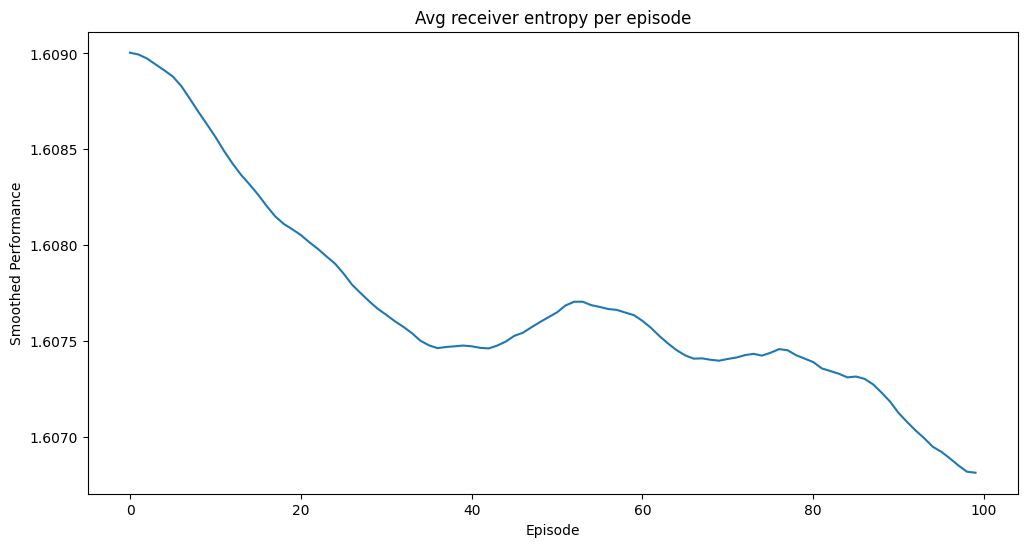

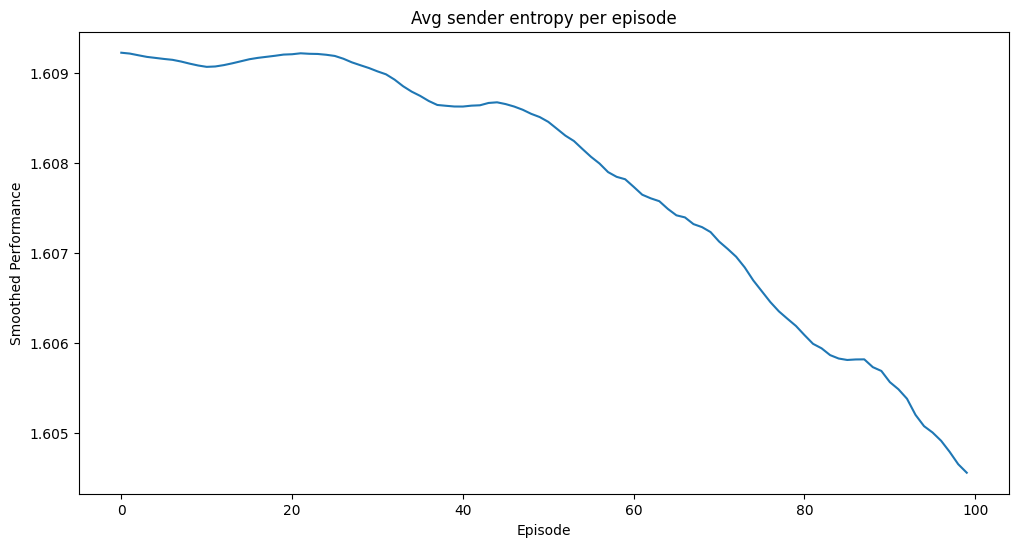

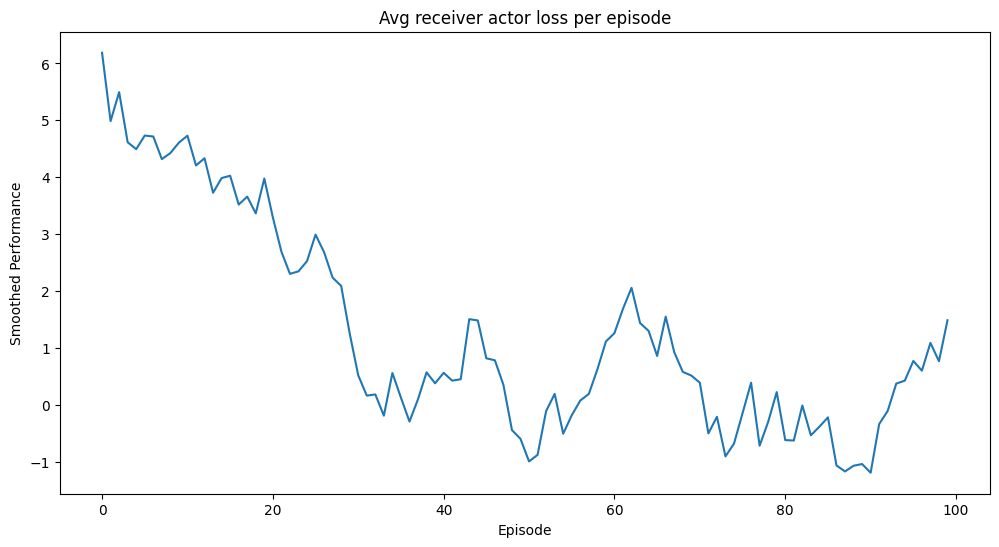

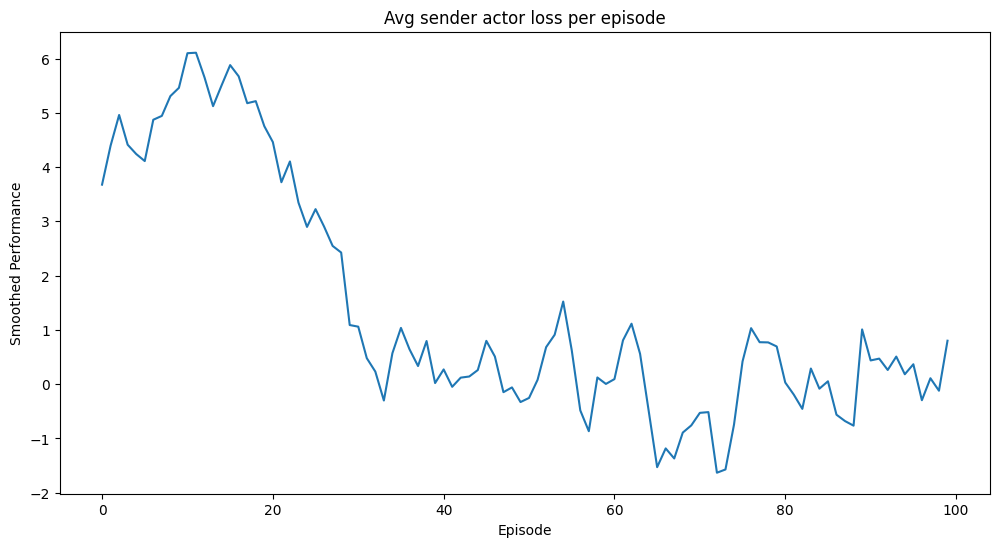

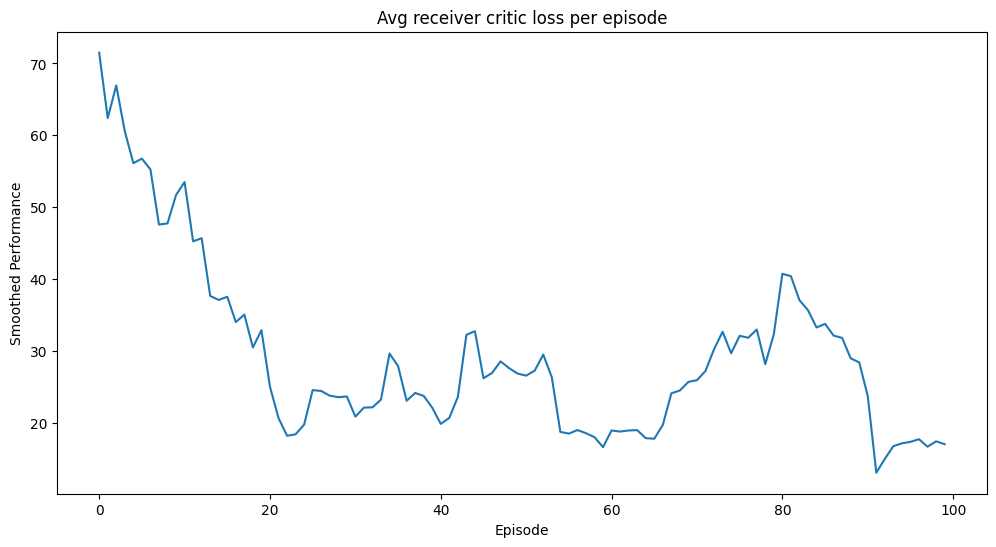

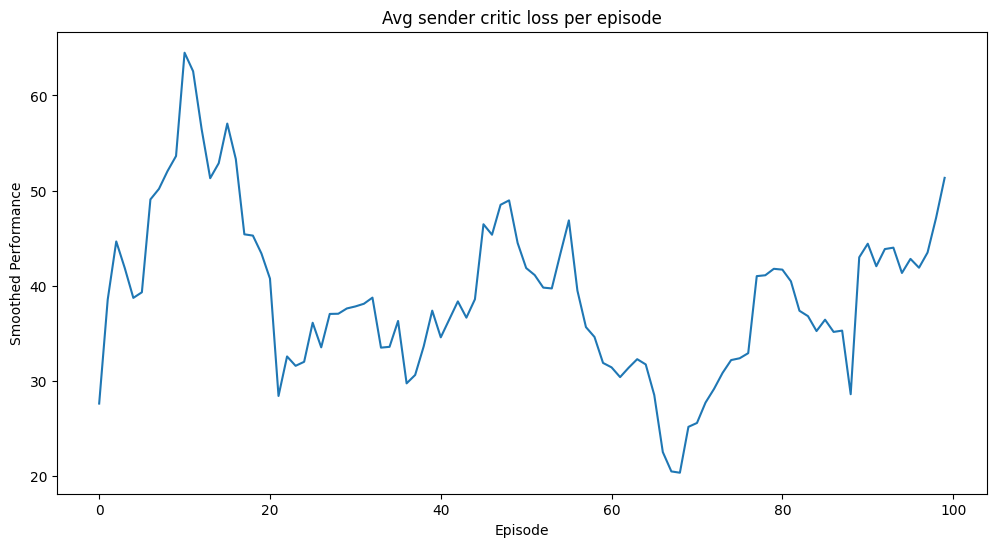

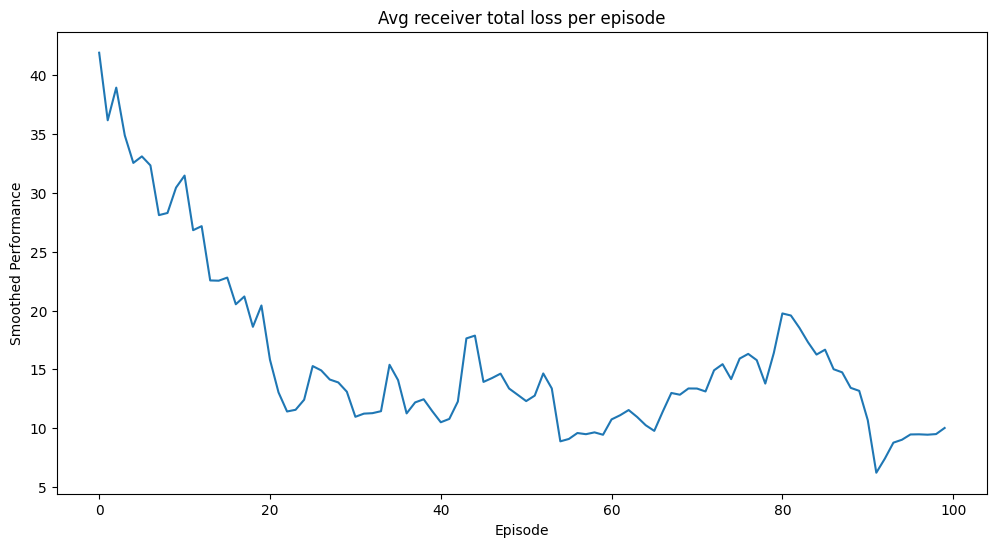

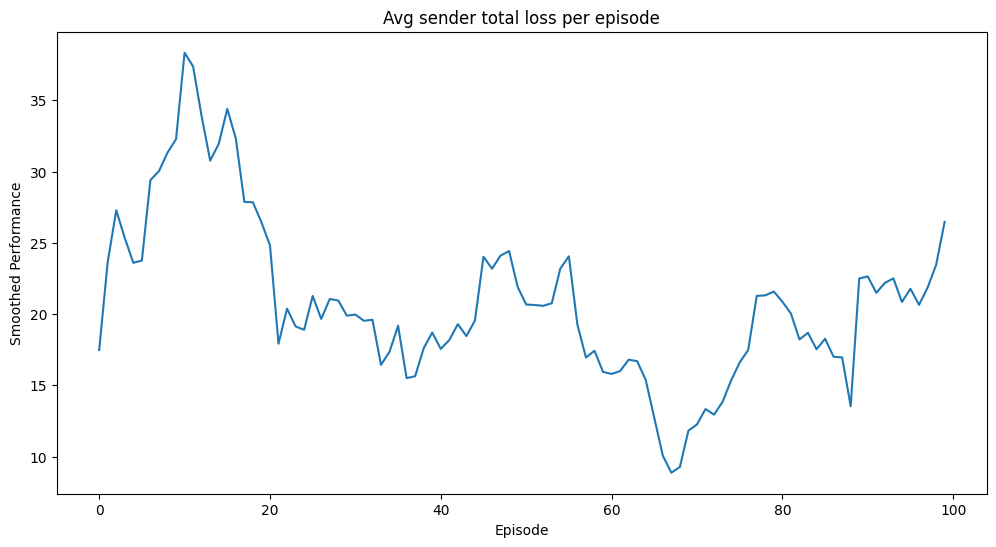

In [17]:
import numpy as np
smoothing_window = max(len(all_stats['performances_dist']) // 20, 1)

# performance
plot_stats(smoothing_window, all_stats['performances_dist'], "Overall performance", plots_folder)
# final rewards
plot_stats(smoothing_window, all_stats['final_rewards_dist'], "Final rewards", plots_folder)
# episode lengths
plot_stats(smoothing_window, all_stats['episode_lengths_dist'], "Episode lengths", plots_folder)

# avg instant rewards for each actor per episode
tmp = [total/length for total, length in zip(all_stats['receiver_instant_rewards_dist'], all_stats['episode_lengths_dist'])]
plot_stats(smoothing_window, tmp, "Avg receiver instant rewards per episode", plots_folder)
tmp = [total/length for total, length in zip(all_stats['sender_instant_rewards_dist'], all_stats['episode_lengths_dist'])]
plot_stats(smoothing_window, tmp, "Avg sender instant rewards per episode", plots_folder)
# avg useless actions for each actor per episode
tmp = [total/length for total, length in zip(all_stats['useless_actions_sender_dist'], all_stats['episode_lengths_dist'])]
plot_stats(smoothing_window, tmp, "Avg useless sender actions per episode", plots_folder)
tmp = [total/length for total, length in zip(all_stats['useless_actions_receiver_dist'], all_stats['episode_lengths_dist'])]
plot_stats(smoothing_window, tmp, "Avg useless receiver actions per episode", plots_folder)
# avg empty actions for each actor per episode
tmp = [total/length for total, length in zip(all_stats['empty_actions_sender_dist'], all_stats['episode_lengths_dist'])]
plot_stats(smoothing_window, tmp, "Avg empty sender actions per episode", plots_folder)
tmp = [total/length for total, length in zip(all_stats['empty_actions_receiver_dist'], all_stats['episode_lengths_dist'])]
plot_stats(smoothing_window, tmp, "Avg empty receiver actions per episode", plots_folder)

# avg entropy for each actor per episode (already means—plot directly)
tmp = [np.mean(ep) if ep else 0 for ep in all_stats['receiver_entropy_dist']]
plot_stats(smoothing_window, tmp, "Avg receiver entropy per episode", plots_folder)
tmp = [np.mean(ep) if ep else 0 for ep in all_stats['sender_entropy_dist']]
plot_stats(smoothing_window, tmp, "Avg sender entropy per episode", plots_folder)
# avg actor loss for each actor per episode (already means)
tmp = [np.mean(ep) if ep else 0 for ep in all_stats['receiver_actor_loss_dist']]
plot_stats(smoothing_window, tmp, "Avg receiver actor loss per episode", plots_folder)
tmp = [np.mean(ep) if ep else 0 for ep in all_stats['sender_actor_loss_dist']]
plot_stats(smoothing_window, tmp, "Avg sender actor loss per episode", plots_folder)
# avg critic loss for each actor per episode (already means)
tmp = [np.mean(ep) if ep else 0 for ep in all_stats['receiver_critic_loss_dist']]
plot_stats(smoothing_window, tmp, "Avg receiver critic loss per episode", plots_folder)
tmp = [np.mean(ep) if ep else 0 for ep in all_stats['sender_critic_loss_dist']]
plot_stats(smoothing_window, tmp, "Avg sender critic loss per episode", plots_folder)
# avg total loss for each actor per episode (already means)
tmp = [np.mean(ep) if ep else 0 for ep in all_stats['receiver_total_loss_dist']]
plot_stats(smoothing_window, tmp, "Avg receiver total loss per episode", plots_folder)
tmp = [np.mean(ep) if ep else 0 for ep in all_stats['sender_total_loss_dist']]
plot_stats(smoothing_window, tmp, "Avg sender total loss per episode", plots_folder)